# Credit Card Fraud Detection - Model Building

Build machine learning models with techniques to handle class imbalance.

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, f1_score, precision_score,
    recall_score, auc
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('creditcard.csv')
print(f"Dataset loaded: {df.shape}")

Dataset loaded: (284807, 31)


## 2. Data Preparation

In [2]:
print("="*80)
print("DATA PREPARATION FOR MODELING")
print("="*80 + "\n")

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass ratio:")
print(y.value_counts(normalize=True) * 100)

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled successfully!")

DATA PREPARATION FOR MODELING

Features shape: (284807, 30)
Target shape: (284807,)

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Class ratio:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

Training set size: (199364, 30)
Testing set size: (85443, 30)

Training set class distribution:
Class
0    199020
1       344
Name: count, dtype: int64

Features scaled successfully!


## 3. Train Models with Imbalance Handling

In [3]:
print("\n" + "="*80)
print("TRAINING MODELS WITH IMBALANCE HANDLING TECHNIQUES")
print("="*80 + "\n")

models_results = {}

# 1. Logistic Regression with class weights
print("1. Training Logistic Regression with class weights...")
lr_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
models_results['Logistic Regression'] = {
    'model': lr_model,
    'predictions': lr_pred,
    'probabilities': lr_pred_proba
}
print("✓ Logistic Regression trained\n")

# 2. Random Forest with class weights
print("2. Training Random Forest with class weights...")
rf_model = RandomForestClassifier(
    n_estimators=100, 
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    max_depth=15
)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
models_results['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_pred,
    'probabilities': rf_pred_proba
}
print("✓ Random Forest trained\n")

# 3. XGBoost
print("3. Training XGBoost...")
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
models_results['XGBoost'] = {
    'model': xgb_model,
    'predictions': xgb_pred,
    'probabilities': xgb_pred_proba
}
print("✓ XGBoost trained\n")

# 4. Logistic Regression with SMOTE
print("4. Training Logistic Regression with SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print(f"   Original training set size: {X_train_scaled.shape}")
print(f"   After SMOTE: {X_train_smote.shape}")
print(f"   Class distribution after SMOTE: {np.bincount(y_train_smote)}")

lr_smote = LogisticRegression(random_state=42, max_iter=1000)
lr_smote.fit(X_train_smote, y_train_smote)
lr_smote_pred = lr_smote.predict(X_test_scaled)
lr_smote_pred_proba = lr_smote.predict_proba(X_test_scaled)[:, 1]
models_results['LR + SMOTE'] = {
    'model': lr_smote,
    'predictions': lr_smote_pred,
    'probabilities': lr_smote_pred_proba
}
print("✓ Logistic Regression with SMOTE trained\n")

print("All models trained successfully!")


TRAINING MODELS WITH IMBALANCE HANDLING TECHNIQUES

1. Training Logistic Regression with class weights...
✓ Logistic Regression trained

2. Training Random Forest with class weights...
✓ Random Forest trained

3. Training XGBoost...
✓ XGBoost trained

4. Training Logistic Regression with SMOTE...
   Original training set size: (199364, 30)
   After SMOTE: (398040, 30)
   Class distribution after SMOTE: [199020 199020]
✓ Logistic Regression with SMOTE trained

All models trained successfully!


## 4. Model Evaluation

In [4]:
print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80 + "\n")

evaluation_results = {}

for model_name, model_data in models_results.items():
    predictions = model_data['predictions']
    probabilities = model_data['probabilities']
    
    # Calculate metrics
    accuracy = (predictions == y_test).mean()
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, probabilities)
    
    evaluation_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    print(f"{model_name}:")
    print("-" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (% of predicted fraud that is actual fraud)")
    print(f"Recall:    {recall:.4f} (% of actual fraud detected)")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predictions, target_names=['Legitimate', 'Fraud']))

# Create comparison DataFrame
evaluation_df = pd.DataFrame(evaluation_results).T
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(evaluation_df.round(4))

# Find best model
best_model_name = evaluation_df['ROC-AUC'].idxmax()
print(f"\n✓ Best performing model: {best_model_name} (ROC-AUC: {evaluation_df.loc[best_model_name, 'ROC-AUC']:.4f})")


MODEL EVALUATION

Logistic Regression:
--------------------------------------------------
Accuracy:  0.9786
Precision: 0.0671 (% of predicted fraud that is actual fraud)
Recall:    0.8784 (% of actual fraud detected)
F1-Score:  0.1247
ROC-AUC:   0.9681

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      0.98      0.99     85295
       Fraud       0.07      0.88      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443

Random Forest:
--------------------------------------------------
Accuracy:  0.9994
Precision: 0.9304 (% of predicted fraud that is actual fraud)
Recall:    0.7230 (% of actual fraud detected)
F1-Score:  0.8137
ROC-AUC:   0.9382

Classification Report:
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00     85295
       Fraud       0.93      0.72

## 5. Model Performance Visualizations


VISUALIZING MODEL PERFORMANCE



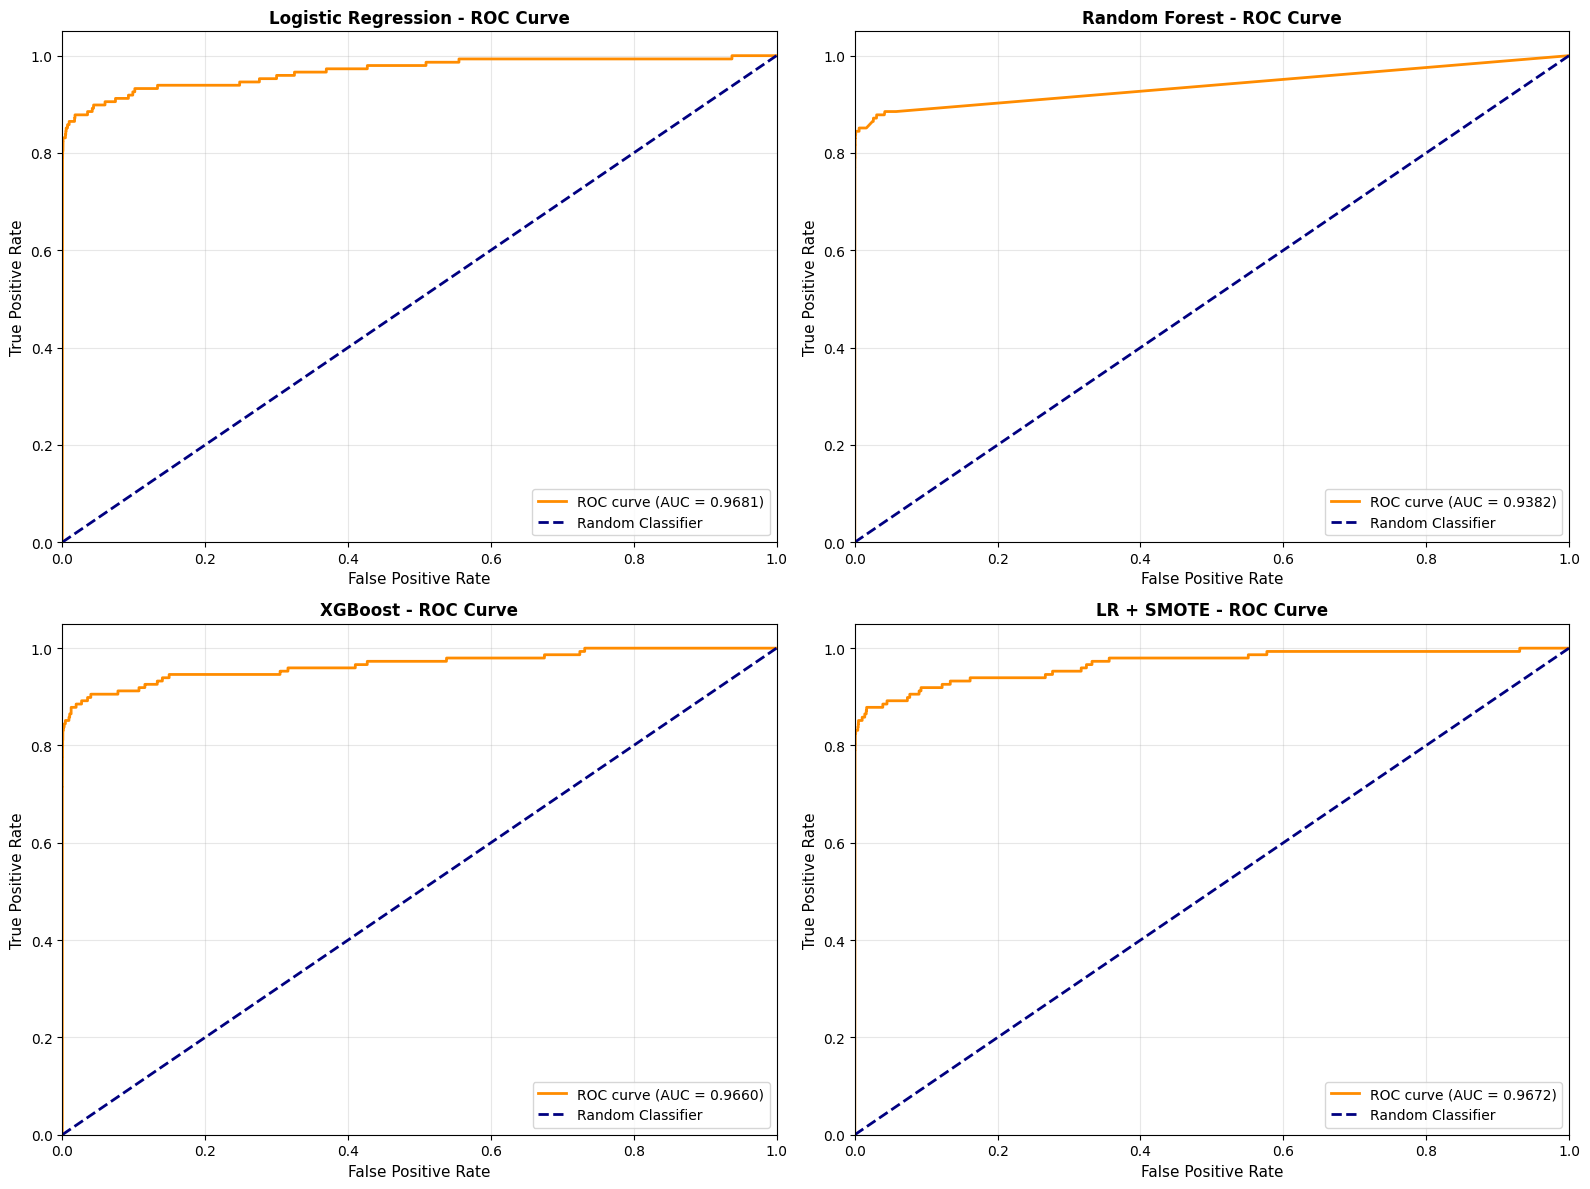

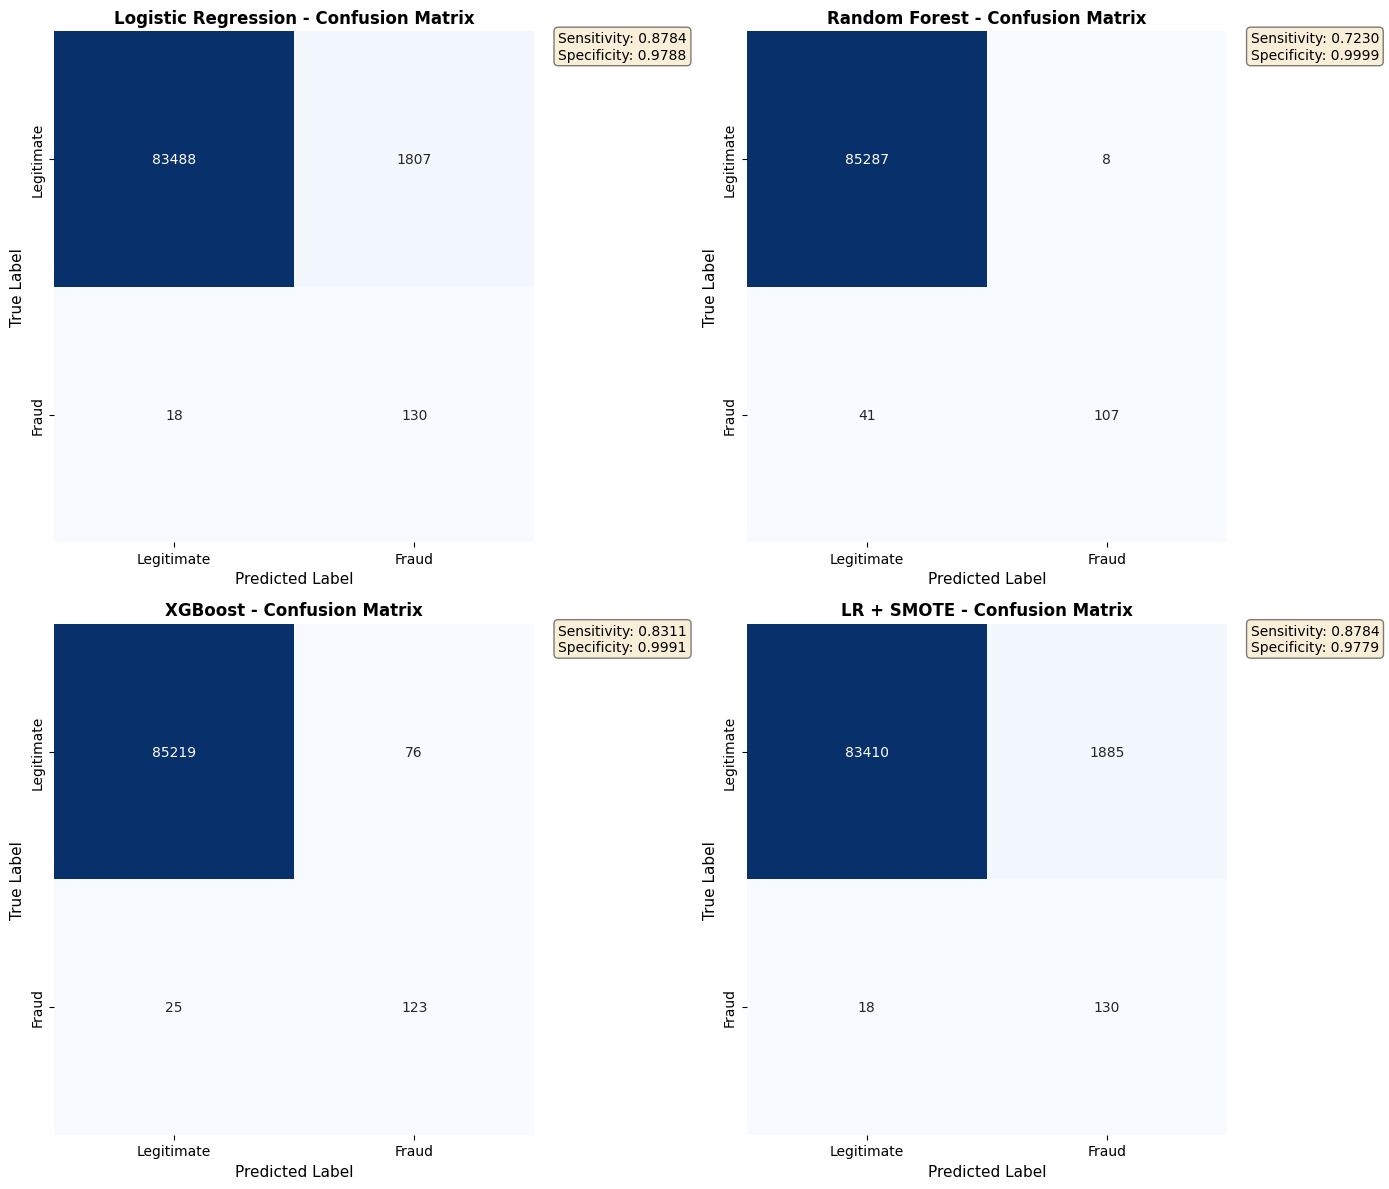

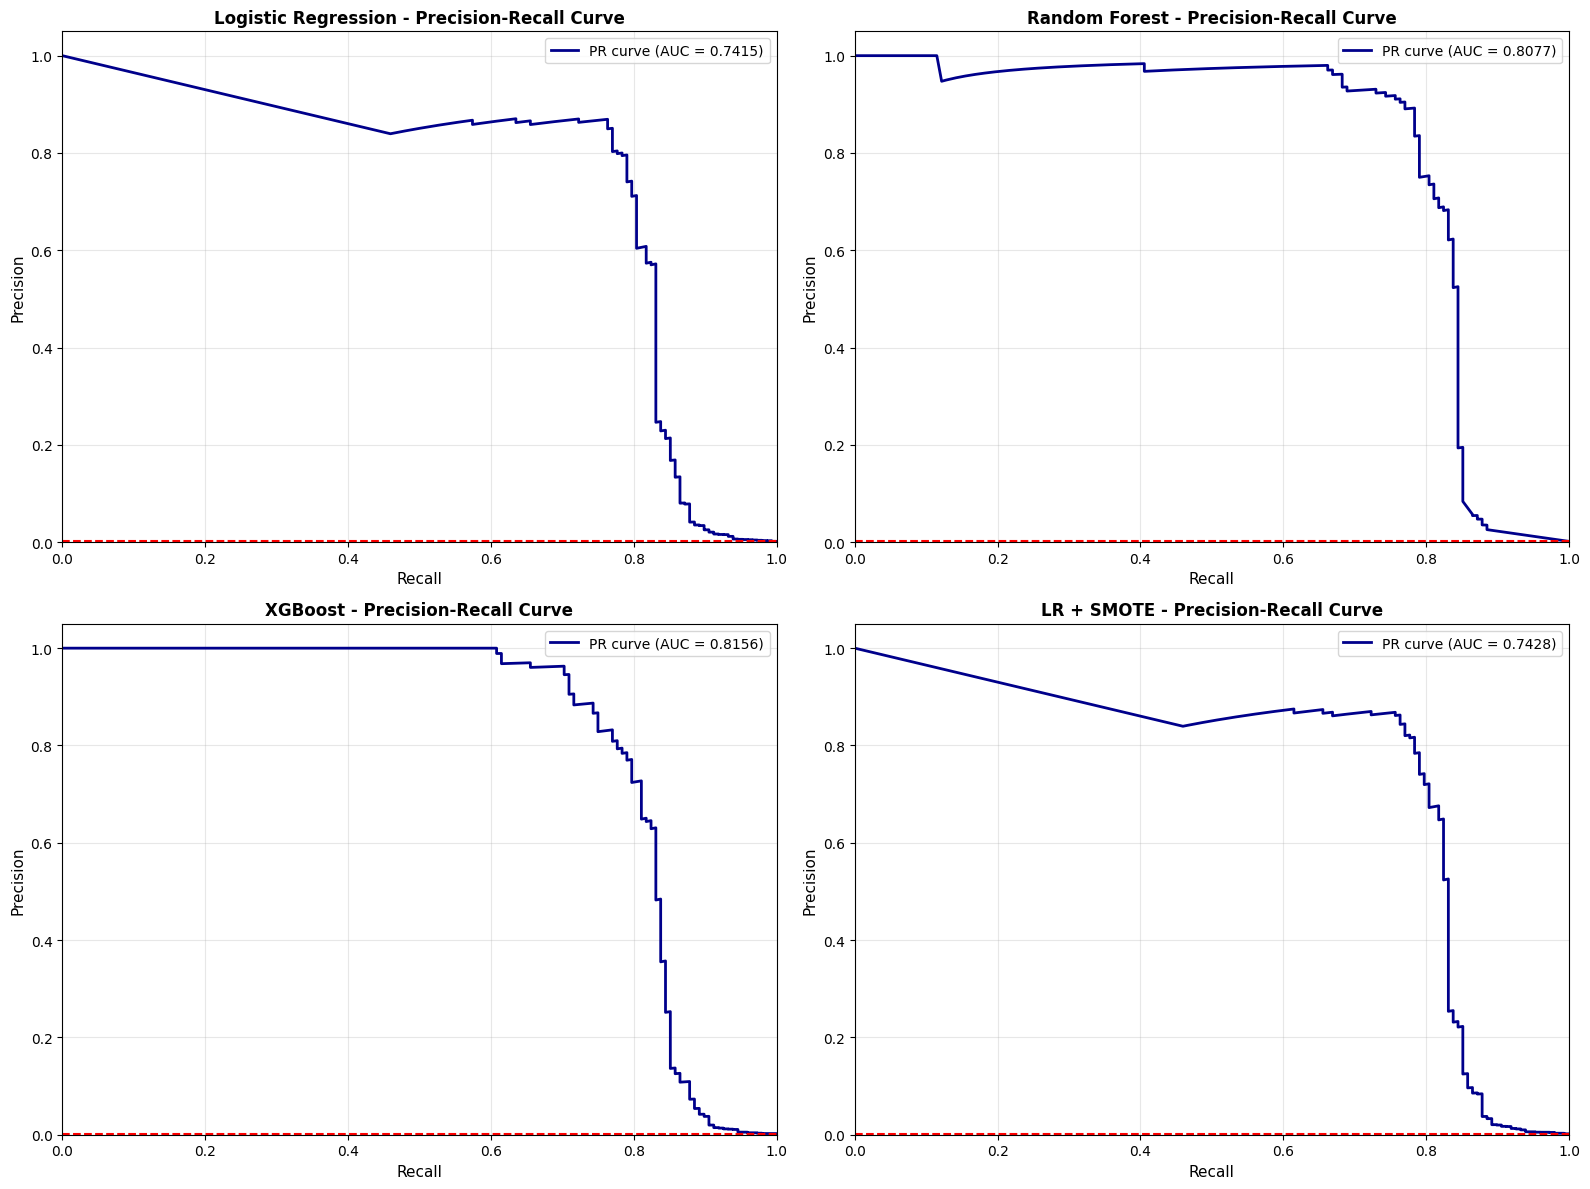

✓ Visualizations complete!


In [5]:
print("\n" + "="*80)
print("VISUALIZING MODEL PERFORMANCE")
print("="*80 + "\n")

# ROC Curves Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (model_name, model_data) in enumerate(models_results.items()):
    probabilities = model_data['probabilities']
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    roc_auc = roc_auc_score(y_test, probabilities)
    
    ax = axes[idx]
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'{model_name} - ROC Curve', fontsize=12, fontweight='bold')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, (model_name, model_data) in enumerate(models_results.items()):
    predictions = model_data['predictions']
    cm = confusion_matrix(y_test, predictions)
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    ax.set_title(f'{model_name} - Confusion Matrix', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xlabel('Predicted Label', fontsize=11)
    
    # Add metrics
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    metrics_text = f'Sensitivity: {sensitivity:.4f}\nSpecificity: {specificity:.4f}'
    ax.text(1.05, 1, metrics_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Precision-Recall Curves
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (model_name, model_data) in enumerate(models_results.items()):
    probabilities = model_data['probabilities']
    
    precision, recall_vals, _ = precision_recall_curve(y_test, probabilities)
    pr_auc = auc(recall_vals, precision)
    
    ax = axes[idx]
    ax.plot(recall_vals, precision, color='darkblue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title(f'{model_name} - Precision-Recall Curve', fontsize=12, fontweight='bold')
    ax.legend(loc="upper right", fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.axhline(y=y_test.value_counts()[1]/len(y_test), color='r', linestyle='--',
               label='Fraud Rate in Data')

plt.tight_layout()
plt.show()

print("✓ Visualizations complete!")

## 6. Feature Importance Analysis


FEATURE IMPORTANCE ANALYSIS

Random Forest - Top 15 Most Important Features:
Feature  Importance
    V14    0.188799
    V10    0.120999
     V4    0.111486
    V12    0.099836
    V17    0.087269
     V3    0.066449
    V11    0.048100
    V16    0.044507
     V2    0.037389
     V9    0.026618
    V21    0.020897
     V7    0.014099
    V18    0.012039
    V19    0.010554
 Amount    0.009466


XGBoost - Top 15 Most Important Features:
Feature  Importance
    V14    0.480405
     V4    0.065627
    V12    0.041280
    V10    0.034865
    V20    0.029153
 Amount    0.027984
    V21    0.022725
    V13    0.020884
     V8    0.018710
    V18    0.018550
    V17    0.018417
    V23    0.018401
    V27    0.017743
    V25    0.015975
    V26    0.014966


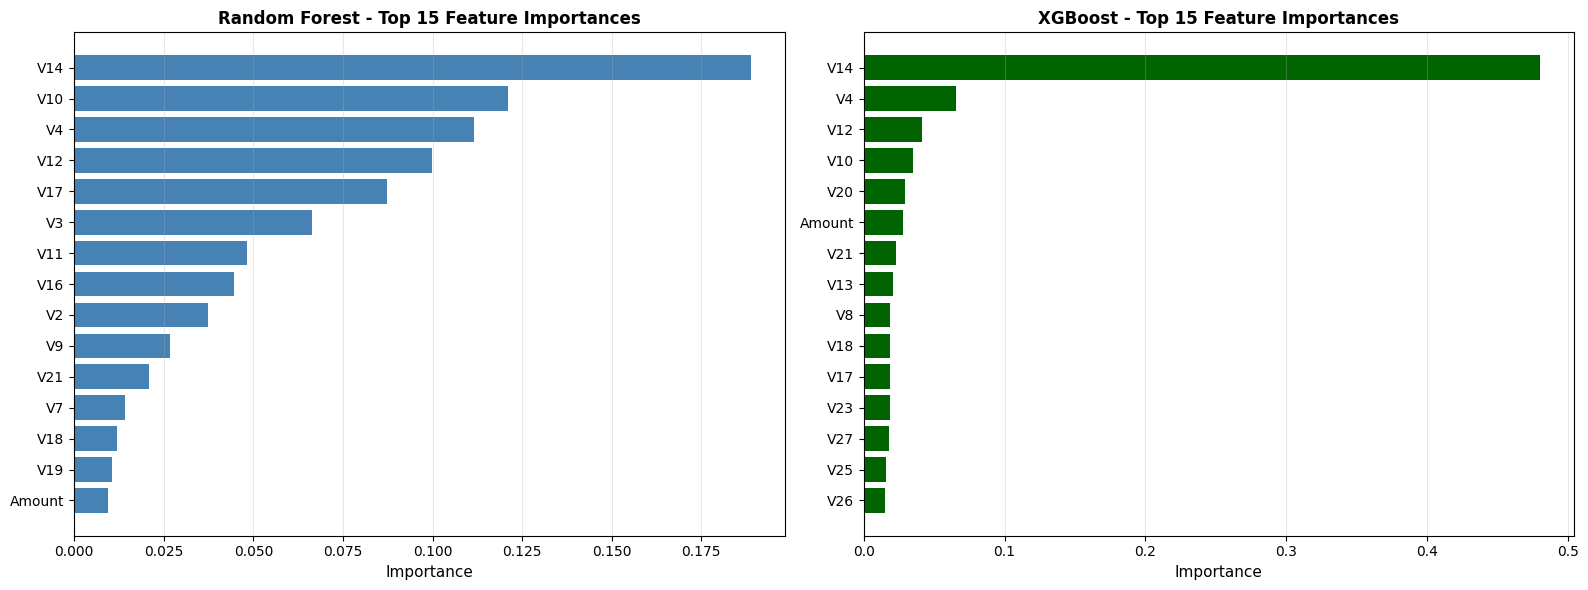


✓ Feature importance analysis complete!


In [6]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80 + "\n")

# Random Forest feature importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models_results['Random Forest']['model'].feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest - Top 15 Most Important Features:")
print(rf_importance.head(15).to_string(index=False))

# XGBoost feature importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': models_results['XGBoost']['model'].feature_importances_
}).sort_values('Importance', ascending=False)

print("\n\nXGBoost - Top 15 Most Important Features:")
print(xgb_importance.head(15).to_string(index=False))

# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
top_features_rf = rf_importance.head(15)
axes[0].barh(range(len(top_features_rf)), top_features_rf['Importance'].values, color='steelblue')
axes[0].set_yticks(range(len(top_features_rf)))
axes[0].set_yticklabels(top_features_rf['Feature'].values)
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('Random Forest - Top 15 Feature Importances', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

# XGBoost
top_features_xgb = xgb_importance.head(15)
axes[1].barh(range(len(top_features_xgb)), top_features_xgb['Importance'].values, color='darkgreen')
axes[1].set_yticks(range(len(top_features_xgb)))
axes[1].set_yticklabels(top_features_xgb['Feature'].values)
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('XGBoost - Top 15 Feature Importances', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n✓ Feature importance analysis complete!")

## 7. Summary and Recommendations

In [7]:
print("\n" + "="*80)
print("MODEL SUMMARY & RECOMMENDATIONS")
print("="*80 + "\n")

print("Class Imbalance Handling Techniques Used:")
print("-" * 50)
print("1. Class Weights: Adjusts algorithm penalties for minority class")
print("2. SMOTE: Synthetically generates minority class samples")
print("3. Scale-Pos-Weight (XGBoost): Weights positive class during training")
print("4. Stratified Train-Test Split: Maintains class distribution")
print("5. Appropriate Metrics: Focus on Precision, Recall, F1, ROC-AUC")
print("   (not just Accuracy, which is misleading for imbalanced data)\n")

print("Key Evaluation Metrics Explanation:")
print("-" * 50)
print("• Precision: Of predicted fraud, how many are actual fraud?")
print("             (Important to minimize false positives - blocking legit transactions)")
print("• Recall: Of actual fraud, how many are detected?")
print("          (Important to minimize false negatives - missing fraudulent transactions)")
print("• F1-Score: Balance between Precision and Recall")
print("• ROC-AUC: Overall discrimination ability of the model")
print("           (1.0 = perfect, 0.5 = random classifier)\n")

print("Model Performance Summary:")
print("-" * 50)
print(evaluation_df.to_string())

print(f"\n\nBest Performing Model: {best_model_name}")
print(f"ROC-AUC Score: {evaluation_df.loc[best_model_name, 'ROC-AUC']:.4f}")
print(f"Recall: {evaluation_df.loc[best_model_name, 'Recall']:.4f} (fraud detection rate)")
print(f"Precision: {evaluation_df.loc[best_model_name, 'Precision']:.4f} (false positive rate)")

print("\nRecommendations:")
print("-" * 50)
print("1. Use ROC-AUC as the primary evaluation metric for model selection")
print("2. Consider business costs of false positives vs false negatives")
print("3. The best model balances Precision/Recall for your use case")
print("4. Monitor precision to avoid blocking legitimate transactions")
print("5. Ensure recall is high to catch fraudulent transactions")
print("6. Implement model monitoring in production")
print("7. Regularly retrain with new data to adapt to evolving fraud patterns")
print("8. Consider ensemble of models for robust predictions")
print("9. Set fraud detection threshold based on business requirements")


MODEL SUMMARY & RECOMMENDATIONS

Class Imbalance Handling Techniques Used:
--------------------------------------------------
1. Class Weights: Adjusts algorithm penalties for minority class
2. SMOTE: Synthetically generates minority class samples
3. Scale-Pos-Weight (XGBoost): Weights positive class during training
4. Stratified Train-Test Split: Maintains class distribution
5. Appropriate Metrics: Focus on Precision, Recall, F1, ROC-AUC
   (not just Accuracy, which is misleading for imbalanced data)

Key Evaluation Metrics Explanation:
--------------------------------------------------
• Precision: Of predicted fraud, how many are actual fraud?
             (Important to minimize false positives - blocking legit transactions)
• Recall: Of actual fraud, how many are detected?
          (Important to minimize false negatives - missing fraudulent transactions)
• F1-Score: Balance between Precision and Recall
• ROC-AUC: Overall discrimination ability of the model
           (1.0 = perfe